In [1]:
GENERATED_PATH = 'generated'

FRAME = 29

CALIBRATION = 0.089

SCALEBAR_POS = [370, 420]
SCALEBAR_SIZE = 5.0

FOR_PUBLICATION = False

In [2]:
import re
import json
import pickle
from pathlib import Path

import numpy as np
import cv2
from matplotlib import pyplot

from pycocotools._mask import decode

In [3]:
def get_yolo(fname, shape, score_threshold=0.5):
    data = np.loadtxt(fname)
    # class, x, y, w, h, score
    data = data[data[:, 5] > score_threshold, :]
    
    X, Y, W, H = data[:, 1] * shape[0], data[:, 2] * shape[1], data[:, 3] * shape[0], data[:, 4] * shape[1]
    
    contours = []
    
    for x, y, w, h in zip(X, Y, W, H):
        contours.append(np.array([
            [x - w/2.0, y - h/2.0],
            [x - w/2.0, y + h/2.0],
            [x + w/2.0, y + h/2.0],
            [x + w/2.0, y - h/2.0],
            [x - w/2.0, y - h/2.0],            
        ]))

    return contours


def get_mmdetection(mmdetection_pkl, score_threshold=0.5):

    mmdetection_data = pickle.loads(mmdetection_pkl.read_bytes())

    mmdetection_frame = mmdetection_data[FRAME]
    mmdetection_bbox_scores = mmdetection_frame[0][0]
    mmdetection_score_threshold = 0.5
    mmdetection_masks = [
        decode([encoded_mask])[:, :, 0] 
        for encoded_mask, bbox_score
        in zip(mmdetection_frame[1][0], mmdetection_bbox_scores)
        if bbox_score[4] > score_threshold
    ]

    mmdetection_contours = [
        cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0][:, 0]
        for mask in mmdetection_masks
    ]
    
    return mmdetection_contours


def center_based_nms(contours, delta=5.0):
    delta_sq = delta ** 2
    all_moments = [cv2.moments(contour.astype(np.float32)) for contour in contours]
    areas = [m['m00'] for m in all_moments]
    mapping = [(np.array((m['m10'], m['m01']))/m['m00'], contour)
               for contour, m in zip(contours, all_moments)
              ]
    
    neighborhoods = {index: set() for index, _ in enumerate(mapping)}
    
    for index, (center, contour) in enumerate(mapping):
        for index2, (center2, contour2) in list(enumerate(mapping))[index+1:]:
            dist = ((center - center2) ** 2).sum()

            if dist > delta_sq:
                continue
            neighborhoods[index].add(index2)
            neighborhoods[index2].add(index)
    
    originals, duplicates = set(), set()

    for index, indices in neighborhoods.items():
        if index in duplicates:
            continue
        
        all_indices = {index} | indices
        largest = list(sorted(all_indices, key=lambda idx: areas[idx], reverse=True))[0]
        
        originals.add(largest)
        all_indices.remove(largest)
        duplicates |= all_indices
        

    originals_contours = [
        contour
        for index, contour in enumerate(contours)
        if index in originals
    ]
    
    return originals_contours


def join_contours(l):
    new_l = []
    
    spacer = np.array([[np.nan, np.nan]])
    
    new_l.append(spacer)

        
    for ll in l:
        new_l.append(ll)
        new_l.append(ll[0:1, :])
        new_l.append(spacer)
                
    return np.concatenate(new_l, axis=0)


if FOR_PUBLICATION:
    try:
        import tikzplotlib
    except ImportError:
        !pip install git+https://github.com/csachs/matplotlib2tikz.git@embeddable_images_new
        import tikzplotlib

        
class ImagePlotter:
    def __init__(self, image):        
        self.dpi = 72
        self.fig = pyplot.figure(figsize=(image.shape[0] / self.dpi, image.shape[1] / self.dpi))
        
        self.ax = self.fig.add_subplot(1, 1, 1)
        
        self.ax.imshow(image, cmap='gray')
        
        self.ax.axis('off')
        self.ax.set_aspect('equal')
        
    def plot(self, *args, **kwargs):
        self.ax.plot(*args, **kwargs)
        return self
    
    def scalebar(self):
        return self.plot([SCALEBAR_POS[0], SCALEBAR_POS[0] + SCALEBAR_SIZE / CALIBRATION], [SCALEBAR_POS[1], SCALEBAR_POS[1]], color='w', lw=5.0)
        
    def savefig(self, *args, **kwargs):
        if FOR_PUBLICATION:
            import tikzplotlib
            print(tikzplotlib.save(args[0].replace('.pdf' ,'.tex'), embed_images=True, flavor='lualatex'))
        self.fig.savefig(*args, bbox_inches='tight', pad_inches=0, dpi=self.dpi, transparent=True, **kwargs)
        return self

In [4]:
generated_path = Path(GENERATED_PATH)

realcells = generated_path / "realcells"

mmdetection_log = generated_path / "mmdetection-train.log"
yolo_log = generated_path / "yolo-predict.log"

mmdetection_pkl = generated_path / "mmdetection-work_dirs" / "mask_rcnn" / "test_out.pkl"
yolo_labels = generated_path / "yolo-runs" / "test" / "exp" / "labels"

frame_filename = list(sorted((realcells / "val").glob('*.png')))[FRAME]
yolo_filename = list(sorted(yolo_labels.glob('*.txt')))[FRAME]

ground_truth_annotations_filename = realcells / "annotations.json"

In [5]:
print(f"Opening image {frame_filename}")
print(f"... with YOLO bboxes {yolo_filename}")
print(f"... and MMDetection predictions {mmdetection_pkl}")

image = cv2.imread(str(frame_filename))

ground_truth_annotations = json.loads(ground_truth_annotations_filename.read_text())
ground_truth_contours = [
    np.array(ground_truth_annotation['segmentation'][0]).reshape((-1, 2))
    for ground_truth_annotation
    in ground_truth_annotations['annotations']
    if ground_truth_annotation['image_id'] == FRAME   
]

yolo_boxes = get_yolo(yolo_filename, image.shape)
mmdetection_contours = get_mmdetection(mmdetection_pkl)


Opening image generated/realcells/val/000000000029.png
... with YOLO bboxes generated/yolo-runs/test/exp/labels/000000000029.txt
... and MMDetection predictions generated/mmdetection-work_dirs/mask_rcnn/test_out.pkl


raw object count = 0
gt object count = 251
yolo object count = 253
mmdet object count = 251


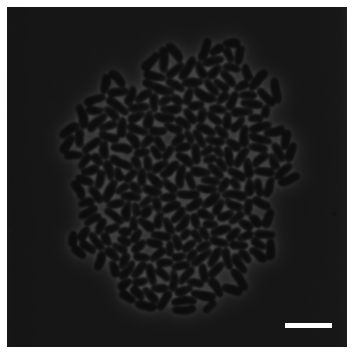

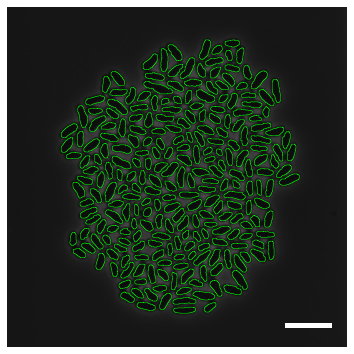

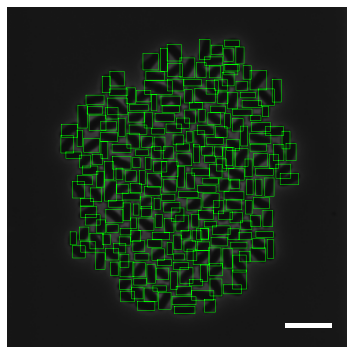

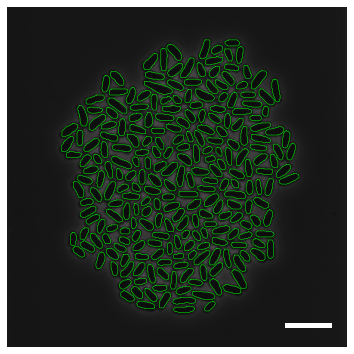

In [6]:
outputs = [
    ('raw', []),
    ('gt', ground_truth_contours),
    ('yolo', yolo_boxes), 
    ('mmdet', mmdetection_contours)
]

for output_name, output_contours in outputs:
    # contours_nms = center_based_nms(output_contours)
    contours_nms = output_contours
    all_contours = join_contours(contours_nms)
    
    print(f"{output_name} object count = {len(contours_nms)}")
    
    (
        ImagePlotter(image)
            .plot(all_contours[:, 0], all_contours[:, 1], color=(0,1,0), lw='0.5')
            .scalebar()
            .savefig(f'fig_{output_name}.pdf')
    )

In [7]:
def read_log(p):
    for row in p.open():
        yield row.strip()

def strip_consecutive_whitespace(s):
    return re.sub(r'\s+', ' ', s)

def find_re(pattern, rows, loc='first'):
    re_pattern = re.compile(pattern)
    
    matches = [
        idx
        for idx, row
        in enumerate(rows)
        if re_pattern.match(row)
    ]
    if loc == 'first':
        return matches[0]
    else:
        return matches[-1]

In [8]:
yolo_log_rows = list(map(strip_consecutive_whitespace, read_log(yolo_log)))
y_last_class_row = find_re(r'^Class.*', yolo_log_rows, loc='last')

y_header = yolo_log_rows[y_last_class_row]
y_data = yolo_log_rows[y_last_class_row + 1]

y_header = y_header.replace('mAP@.5:.95', 'mAP@.5|.95').split(':')[0].replace('mAP@.5|.95', 'mAP@.5:.95')

y_data = y_data

yolo_results = {
    key: float(value) if value != 'all' else value
    for key, value
    in zip(y_header.split(' '), y_data.split(' '))
}

yolo_results

{'Class': 'all',
 'Images': 30.0,
 'Targets': 1600.0,
 'P': 0.717,
 'R': 0.994,
 'mAP@.5': 0.994,
 'mAP@.5:.95': 0.667}

In [9]:
mmdetection_log_rows = list(map(strip_consecutive_whitespace, read_log(mmdetection_log)))

mmdetection_last_val_row_idx = find_re(r'.*Epoch\(val\).*', mmdetection_log_rows, loc='last')

mmdetection_last_val_row = mmdetection_log_rows[mmdetection_last_val_row_idx]
mmdetection_last_val_row = mmdetection_last_val_row.split('Epoch(val)')[1].split('] ')[1]

mmdetection_results = {
    f[0]: float(f[1])
    for f in
    [
        frag.split(': ')
        for frag
        in mmdetection_last_val_row.split(', ')
    ]
    if f[0].split('_')[-1] not in ('m', 'l', 'copypaste')
}

mmdetection_results

{'bbox_mAP': 0.465,
 'bbox_mAP_50': 0.987,
 'bbox_mAP_75': 0.67,
 'bbox_mAP_s': 0.598,
 'segm_mAP': 0.47,
 'segm_mAP_50': 0.987,
 'segm_mAP_75': 0.767,
 'segm_mAP_s': 0.614}